# Proyecto - Showz Marketing & Customer Analysis

## Paso 1: Cargar y preparar los datos

En este paso cargamos los tres archivos proporcionados: visitas, pedidos y costos. Convertimos las fechas al formato adecuado y verificamos los tipos de datos para asegurar que estén listos para el análisis.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

# Carga de archivos
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

# Renombrar columnas para facilitar el análisis
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

# Convertir a tipo datetime
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

# Verificar estructura de cada DataFrame
print("visits info:")
visits.info()
print("Primeras filas de visits:")
print(visits.head())

print("orders info:")
orders.info()
print("Primeras filas de orders:")
print(orders.head())

print("costs info:")
costs.info()
print("Primeras filas de costs:")
print(costs.head())

# Verificamos los tipos de datos
print(visits.dtypes)
print(orders.dtypes)
print(costs.dtypes)


visits info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
Primeras filas de visits:
    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  
0  16879256277535

## Paso 2. Haz informes y calcula métricas 

### Paso 2.1 Visitas:

En esta sección exploraremos el comportamiento de visitas de los usuarios:
- ¿Cuántas personas lo usan cada día, semana y mes?
- ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).
- ¿Cuál es la duración de cada sesión?
- ¿Con qué frecuencia los usuarios regresan?

#### Paso 2.1.1 — Usuarios únicos por día, semana y mes (DAU, WAU, MAU)

Calculamos:
- **DAU** (Daily Active Users): cuántos usuarios únicos usan el sitio por día.
- **WAU** (Weekly Active Users): por semana.
- **MAU** (Monthly Active Users): por mes.


In [2]:
# Agregar columnas para año, mes, semana y día
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.isocalendar().week
visits['session_month'] = visits['start_ts'].dt.to_period('M')

# DAU - usuarios únicos por día
dau = visits.groupby('session_date')['uid'].nunique()

# WAU - usuarios únicos por semana
wau = visits.groupby('session_week')['uid'].nunique()

# MAU - usuarios únicos por mes
mau = visits.groupby('session_month')['uid'].nunique()

print(f'Promedio de DAU: {dau.mean():.2f}')
print(f'Promedio de WAU: {wau.mean():.2f}')
print(f'Promedio de MAU: {mau.mean():.2f}')


Promedio de DAU: 907.99
Promedio de WAU: 5825.29
Promedio de MAU: 23228.42


#### Paso 2.1.2 — Número de sesiones por día

Calculamos cuántas sesiones totales se realizaron cada día en el sitio.


In [3]:
sessions_per_day = visits.groupby('session_date')['uid'].count()
print(sessions_per_day.head())


session_date
2017-06-01    664
2017-06-02    658
2017-06-03    477
2017-06-04    510
2017-06-05    893
Name: uid, dtype: int64


#### Paso 2.1.3 — Duración promedio de las sesiones

Calculamos la duración de cada sesión como la diferencia entre `end_ts` y `start_ts`.


count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration_sec, dtype: float64


<AxesSubplot:>

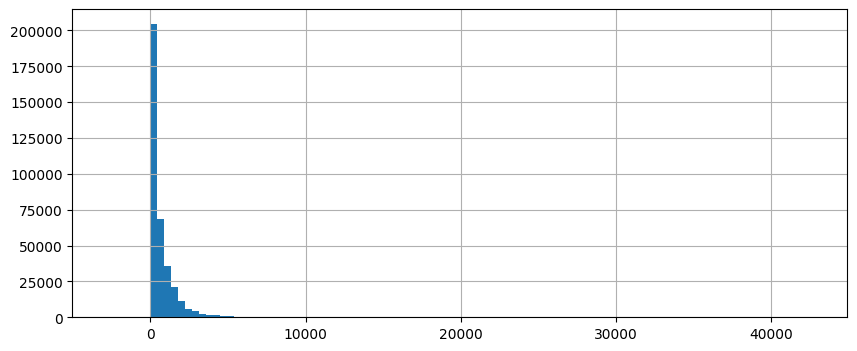

In [4]:
# Calcular duración de sesión en segundos
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()

# Estadísticas generales
print(visits['session_duration_sec'].describe())

# Histograma
visits['session_duration_sec'].hist(bins=100, figsize=(10, 4))


#### Paso 2.1.4 — Frecuencia de retorno

Calculamos cuántos días únicos ha estado activo cada usuario para estimar su frecuencia de retorno.


count    228169.000000
mean          1.448527
std           2.610167
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         259.000000
Name: session_date, dtype: float64


<AxesSubplot:>

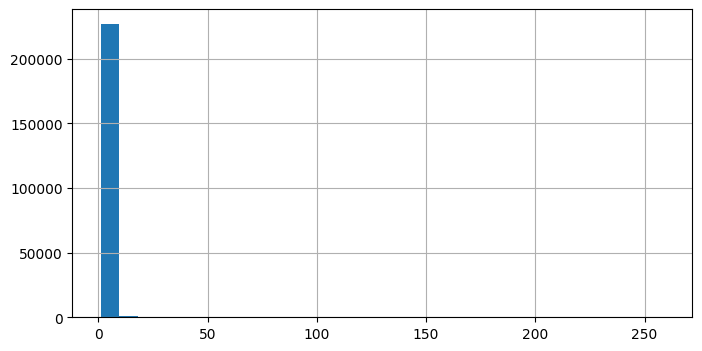

In [5]:
# Días únicos activos por usuario
user_retention = visits.groupby('uid')['session_date'].nunique()

# Estadísticas sobre frecuencia de retorno
print(user_retention.describe())

# Histograma de frecuencia
user_retention.hist(bins=30, figsize=(8, 4))


### 2.2 Análisis de Ventas

En esta sección exploraremos el comportamiento de compra de los usuarios:
- Cuánto tardan en comprar después de su primera visita.
- Cuántos pedidos se generan.
- El tamaño promedio de cada compra.
- El valor que cada cliente aporta en total (LTV).


In [6]:
# Copia segura del DataFrame de pedidos
orders_df = orders.copy()

# Convertir las fechas
orders_df['buy_ts'] = pd.to_datetime(orders_df['buy_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

# Obtener la primera visita de cada usuario
first_visits = visits.groupby('uid')['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_visit_ts']

# Unir pedidos con visitas para saber cuánto tardaron en comprar
orders_merged = orders_df.merge(first_visits, on='uid')

# Calcular la diferencia en días desde la visita hasta la compra
orders_merged['conversion_time'] = (orders_merged['buy_ts'] - orders_merged['first_visit_ts']).dt.days

# Mostrar las primeras filas
orders_merged.head()


,buy_ts,revenue,uid,first_visit_ts,conversion_time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,0


#### 2.2.1 Tiempo hasta la conversión

Analizamos cuántos días tardan los usuarios en hacer su primera compra desde la primera visita.


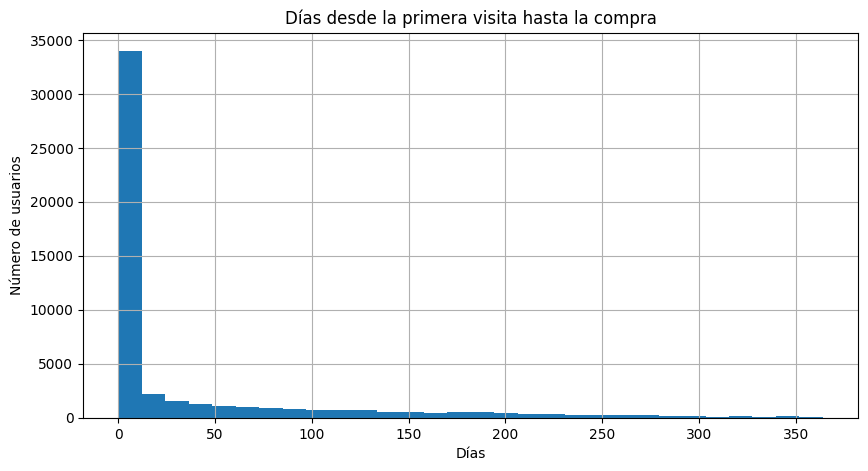

In [7]:
plt.figure(figsize=(10, 5))
orders_merged['conversion_time'].hist(bins=30)
plt.title('Días desde la primera visita hasta la compra')
plt.xlabel('Días')
plt.ylabel('Número de usuarios')
plt.grid(True)
plt.show()


#### 2.2.2 Frecuencia de Compra

La frecuencia de compra indica cuántas veces en promedio un cliente realiza pedidos. Es una métrica útil para entender la lealtad o el retorno del usuario.


In [8]:
# Total de pedidos por usuario
orders_by_user = orders_df.groupby('uid').agg({'buy_ts': 'count'}).reset_index()
orders_by_user.columns = ['uid', 'n_orders']

# Número total de clientes
n_users = orders_by_user.shape[0]

# Número total de pedidos
n_total_orders = orders_df.shape[0]

# Frecuencia promedio de compra por usuario
purchase_frequency = n_total_orders / n_users

print(f"Frecuencia promedio de compra por usuario: {purchase_frequency:.2f} pedidos")


Frecuencia promedio de compra por usuario: 1.38 pedidos


##### 2.2.2.1 Pedidos por mes

In [9]:
# Extraer el mes de compra
orders_df['order_month'] = orders_df['buy_ts'].dt.to_period('M')

# Pedidos por mes
orders_per_month = orders_df.groupby('order_month').agg({
    'buy_ts': 'count',
    'revenue': 'sum'
})
orders_per_month.columns = ['n_orders', 'total_revenue']

orders_per_month.head()


,n_orders,total_revenue
order_month,,
2017-06,2354,9557.49
2017-07,2363,12539.47
2017-08,1807,8758.78
2017-09,3387,18345.51
2017-10,5679,27987.70


#### 2.2.3 Tamaño promedio por compra mensual

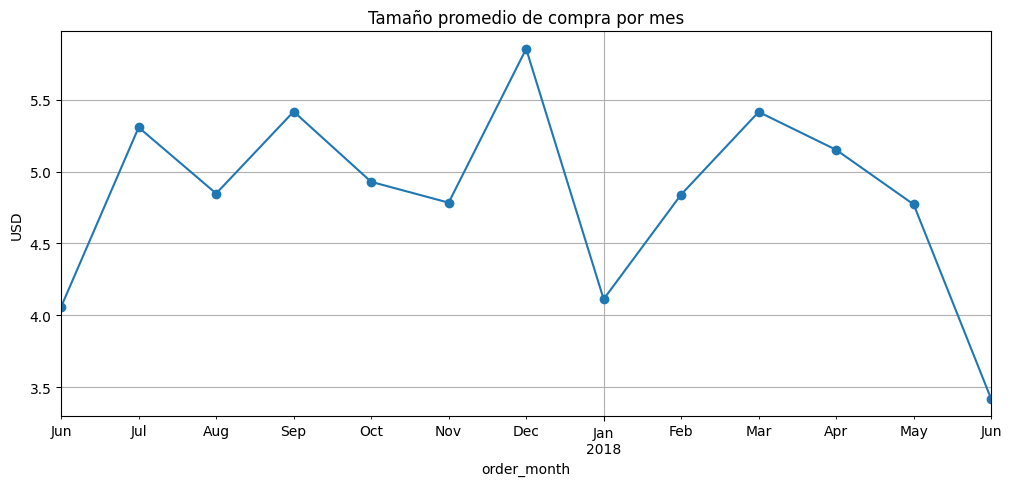

In [10]:
# Calcular tamaño promedio de compra
orders_per_month['avg_order_value'] = orders_per_month['total_revenue'] / orders_per_month['n_orders']

# Gráfico del tamaño promedio de compra
orders_per_month['avg_order_value'].plot(figsize=(12, 5), marker='o', title='Tamaño promedio de compra por mes')
plt.ylabel('USD')
plt.grid(True)
plt.show()

#### 2.2.4 LTV 

Calcularemos el valor del tiempo de vida del cliente (LTV) segmentado por mes de primera compra. Esto nos ayudará a entender cuánto valor generan los usuarios con el tiempo y qué tan efectivas fueron las campañas de adquisición por cohorte.

In [11]:
# Añadir columna de mes de compra al DataFrame de pedidos
orders_df['order_month'] = orders_df['buy_ts'].astype('datetime64[M]')

# Encontrar mes de la primera compra por usuario (cohorte)
first_orders = orders_df.groupby('uid')['order_month'].min().reset_index()
first_orders.columns = ['uid', 'first_order_month']

# Unir a tabla de pedidos
orders_with_cohort = pd.merge(orders_df, first_orders, on='uid')

# Agrupar por cohorte y mes de pedido
cohorts = orders_with_cohort.groupby(['first_order_month', 'order_month']).agg(
    revenue=('revenue', 'sum'),
    n_buyers=('uid', 'nunique')
).reset_index()

# Calcular la edad de la cohorte (meses desde primera compra)
cohorts['cohort_age'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

# Calcular LTV por cohorte: revenue / número de usuarios en la cohorte
cohort_sizes = orders_with_cohort.groupby('first_order_month').agg({'uid': 'nunique'}).rename(columns={'uid': 'n_users'})
cohorts = cohorts.merge(cohort_sizes, on='first_order_month')
cohorts['ltv'] = cohorts['revenue'] / cohorts['n_users']


##### 2.2.4.1 Tabla dinámica del LTV

A continuación, visualizamos la evolución del LTV promedio por cohorte a lo largo del tiempo.


In [12]:
# Tabla dinámica: cohorte vs edad -> LTV promedio
ltv_pivot = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_age',
    values='ltv',
    aggfunc='mean'
).round(2)

ltv_pivot.fillna('', inplace=True)
ltv_pivot


cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


Cada fila representa una cohorte mensual y cada columna muestra el valor promedio acumulado por usuario para esa cohorte en su edad respectiva (mes 0, mes 1, etc.). Esta tabla ayuda a visualizar qué tan rápido los usuarios generan ingresos y si hay diferencias entre cohortes.


##### 2.2.4.2 Visualización del LTV por cohorte (gráfico de líneas)

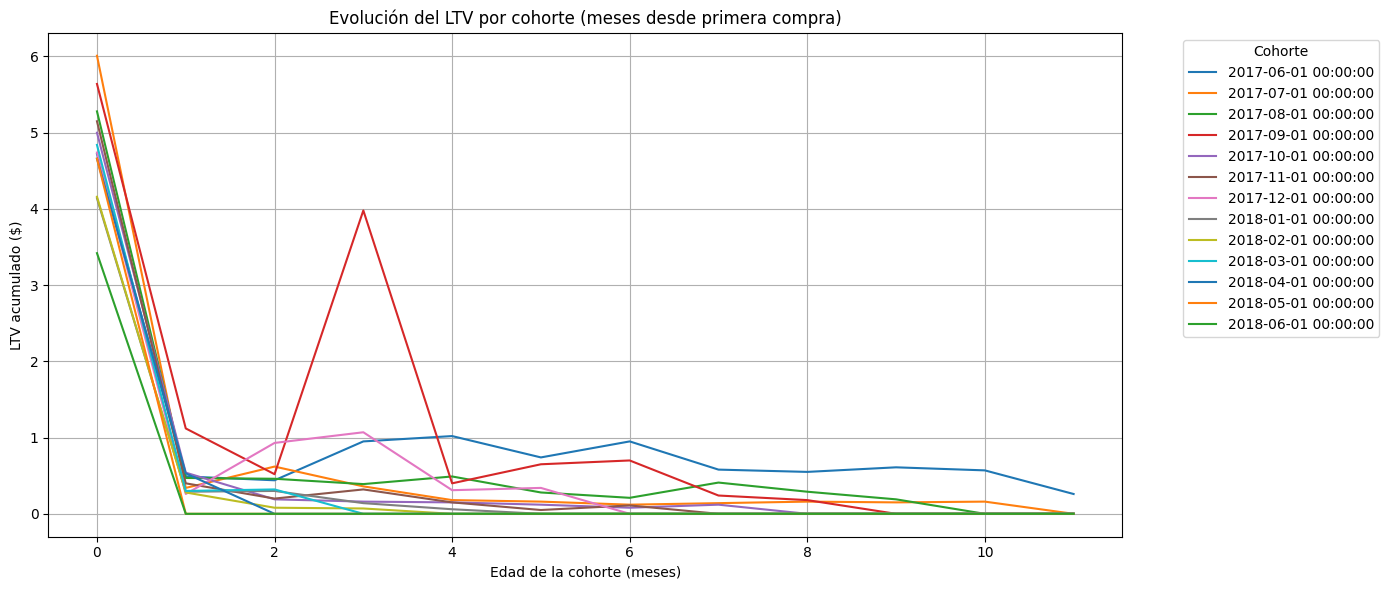

In [13]:
# Asegurarse de que todos los valores de ltv_pivot sean numéricos
ltv_pivot = ltv_pivot.apply(pd.to_numeric, errors='coerce')

# Rellenar NaN con 0
ltv_pivot = ltv_pivot.fillna(0)

# Trazar LTV acumulado por cohorte
plt.figure(figsize=(14, 6))
for cohort in ltv_pivot.index:
    plt.plot(ltv_pivot.columns, ltv_pivot.loc[cohort], label=str(cohort))

plt.title('Evolución del LTV por cohorte (meses desde primera compra)')
plt.xlabel('Edad de la cohorte (meses)')
plt.ylabel('LTV acumulado ($)')
plt.legend(title='Cohorte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Este gráfico muestra cómo evoluciona el Lifetime Value (LTV) para cada cohorte mensual a medida que pasan los meses desde su primera compra.

### Paso 2.3 - Análisis de costos, CAC y ROMI por cohorte

Ahora vincularemos los datos de gastos de marketing con las cohortes de usuarios, para calcular dos métricas importantes:

- **CAC (Customer Acquisition Cost):** cuánto costó adquirir un cliente de una cohorte.
- **ROMI (Return on Marketing Investment):** cuánto retorno generó el cliente en relación con el gasto.

Usaremos los datos del archivo `costs_us.csv`, y los asignaremos a las cohortes mensuales con base en el `source_id`.

In [14]:
# Asegurar formato de fecha correcto en costos
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] = costs['dt'].astype('datetime64[M]')

# Agrupar costos por fuente y mes
monthly_costs = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()
monthly_costs.columns = ['source_id', 'order_month', 'total_costs']
monthly_costs.head()


,source_id,order_month,total_costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Agrupamos los costos por `source_id` y `month`, que representa el mismo periodo que `order_month`. Luego, vinculamos cada pedido con su `source_id` desde la tabla `visits`.


In [15]:
# Vincular source_id a cada orden usando uid
orders_with_source = orders.merge(visits[['uid', 'source_id']], on='uid', how='left')

# Asignar mes de orden y primer mes (cohorte)
orders_with_source['order_month'] = orders_with_source['buy_ts'].astype('datetime64[M]')
orders_with_source['first_order_month'] = orders_with_source.groupby('uid')['order_month'].transform('min')


Agrupamos los datos por cohorte y fuente de adquisición para obtener el número de usuarios únicos, que se usará para calcular el CAC.


In [16]:
cohort_source_users = orders_with_source.groupby(['first_order_month', 'source_id'])['uid'].nunique().reset_index()
cohort_source_users.columns = ['first_order_month', 'source_id', 'n_users']


In [17]:
# Fusionar con los costos mensuales
cac_data = pd.merge(cohort_source_users, monthly_costs, left_on=['first_order_month', 'source_id'], right_on=['order_month', 'source_id'], how='left')

# Calcular CAC = total_costs / n_users
cac_data['cac'] = cac_data['total_costs'] / cac_data['n_users']
cac_data = cac_data[['first_order_month', 'source_id', 'n_users', 'total_costs', 'cac']]
cac_data.head()


,first_order_month,source_id,n_users,total_costs,cac
0,2017-06-01,1,401,1125.61,2.807007
1,2017-06-01,2,457,2427.38,5.311554
2,2017-06-01,3,874,7731.65,8.846281
3,2017-06-01,4,644,3514.80,5.457764
4,2017-06-01,5,571,2616.12,4.581646


Finalmente, calculamos el ROMI comparando el LTV con el CAC.


In [18]:
# Obtener LTV acumulado por cohorte (de la tabla cohorts)
ltv_by_cohort = cohorts.groupby('first_order_month')['ltv'].sum().reset_index()
ltv_by_cohort.columns = ['first_order_month', 'total_ltv']

# Unir con datos de CAC
romi_data = pd.merge(cac_data, ltv_by_cohort, on='first_order_month', how='left')
romi_data['romi'] = romi_data['total_ltv'] / romi_data['cac']
romi_data.head()


,first_order_month,source_id,n_users,total_costs,cac,total_ltv,romi
0,2017-06-01,1,401,1125.61,2.807007,11.879234,4.231992
1,2017-06-01,2,457,2427.38,5.311554,11.879234,2.236489
2,2017-06-01,3,874,7731.65,8.846281,11.879234,1.342851
3,2017-06-01,4,644,3514.80,5.457764,11.879234,2.176575
4,2017-06-01,5,571,2616.12,4.581646,11.879234,2.592787


Este análisis permite identificar qué fuentes de adquisición están generando usuarios más rentables.

En la siguiente sección visualizaremos los resultados para ayudar a los especialistas en marketing a tomar decisiones informadas sobre inversión por fuente.


#### Visualización de CAC y ROMI por fuente

Estas gráficas permiten identificar rápidamente qué fuentes de adquisición fueron más eficientes para Showz durante el periodo analizado.


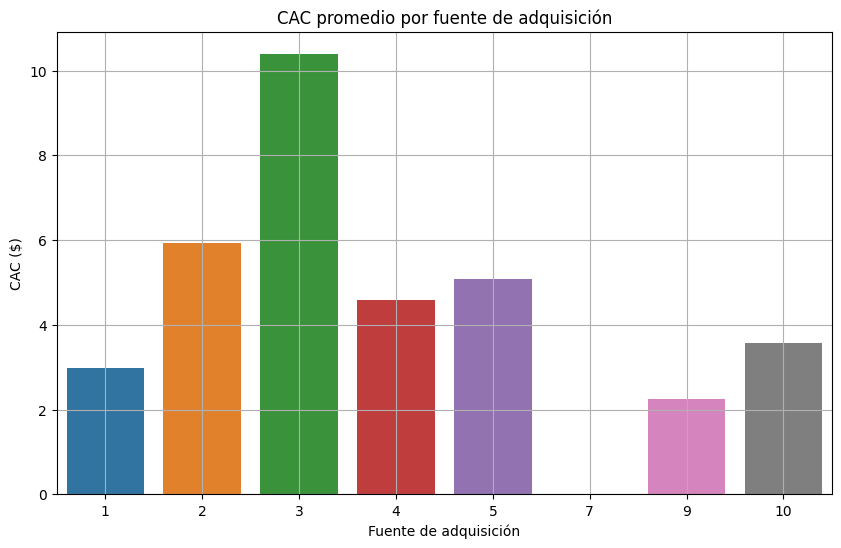

In [19]:
# CAC promedio por fuente
plt.figure(figsize=(10, 6))
sns.barplot(data=cac_data, x='source_id', y='cac', ci=None)
plt.title('CAC promedio por fuente de adquisición')
plt.xlabel('Fuente de adquisición')
plt.ylabel('CAC ($)')
plt.grid(True)
plt.show()


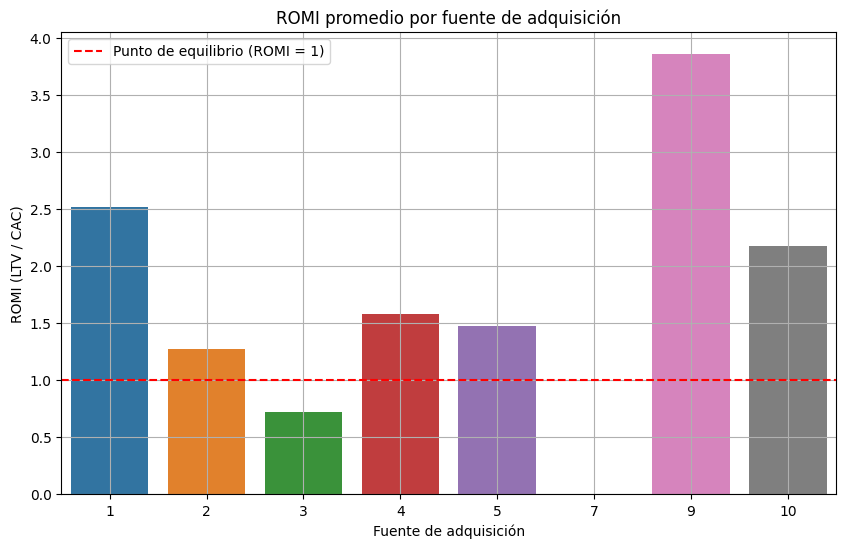

In [20]:
# ROMI promedio por fuente
plt.figure(figsize=(10, 6))
sns.barplot(data=romi_data, x='source_id', y='romi', ci=None)
plt.title('ROMI promedio por fuente de adquisición')
plt.xlabel('Fuente de adquisición')
plt.ylabel('ROMI (LTV / CAC)')
plt.axhline(1, color='red', linestyle='--', label='Punto de equilibrio (ROMI = 1)')
plt.legend()
plt.grid(True)
plt.show()


También podemos observar la evolución mensual del CAC y ROMI por fuente y por cohorte para detectar tendencias o picos en inversión y rentabilidad.


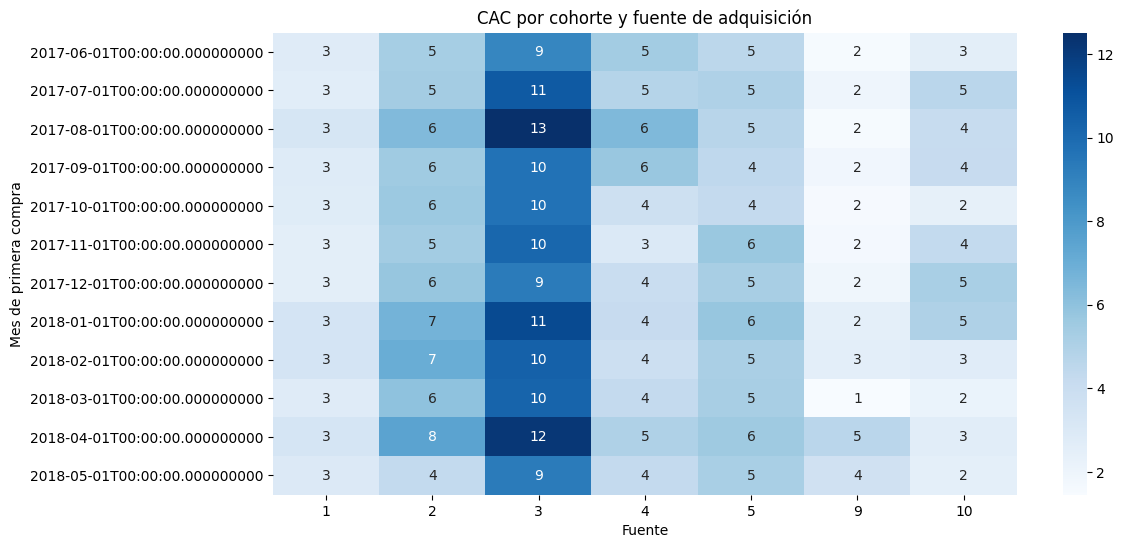

In [21]:
# Tabla dinámica de CAC por cohorte y fuente
cac_heatmap = cac_data.pivot_table(
    index='first_order_month',
    columns='source_id',
    values='cac'
)

plt.figure(figsize=(12, 6))
sns.heatmap(cac_heatmap, annot=True, fmt='.0f', cmap='Blues')
plt.title('CAC por cohorte y fuente de adquisición')
plt.xlabel('Fuente')
plt.ylabel('Mes de primera compra')
plt.show()


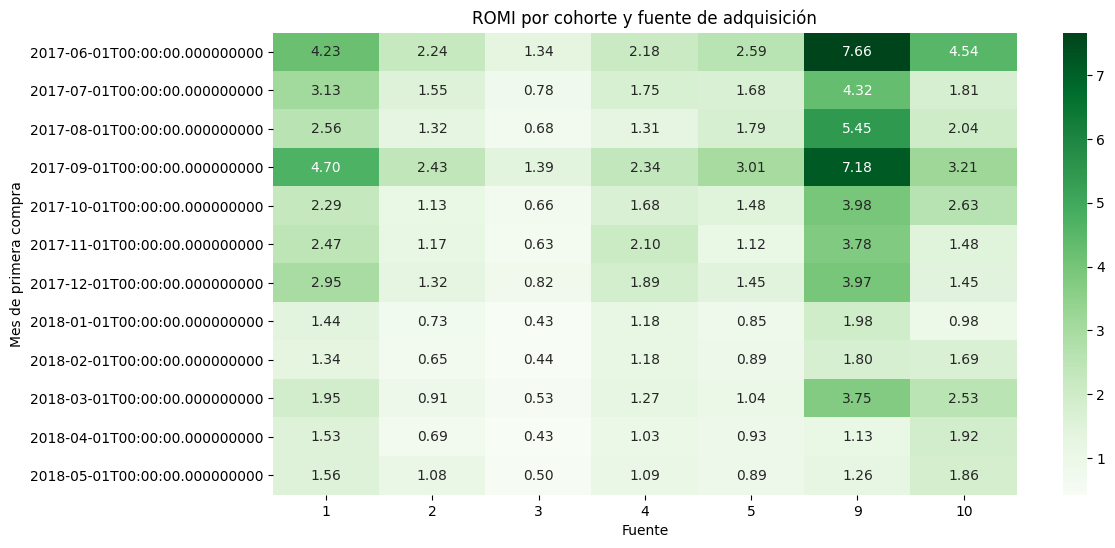

In [22]:
# Tabla dinámica de ROMI por cohorte y fuente
romi_heatmap = romi_data.pivot_table(
    index='first_order_month',
    columns='source_id',
    values='romi'
)

plt.figure(figsize=(12, 6))
sns.heatmap(romi_heatmap, annot=True, fmt='.2f', cmap='Greens')
plt.title('ROMI por cohorte y fuente de adquisición')
plt.xlabel('Fuente')
plt.ylabel('Mes de primera compra')
plt.show()


## Paso 3: Conclusiones y recomendaciones de marketing

### Conclusiones clave del análisis

1. **Duración de sesión y comportamiento de usuarios:**
   - La mayoría de las sesiones duran menos de 15 minutos, con una mediana de solo 5 minutos.
   - Existen valores atípicos que deben ser tratados para evitar sesgos.
   - La retención de usuarios es baja: el 75% solo se conecta un día.

2. **Frecuencia de compra y tiempo hasta la conversión:**
   - Más del 50% de los usuarios convierte el mismo día de su primera visita.
   - Sin embargo, también hay usuarios que tardan semanas o meses en convertir, lo que indica valor en esfuerzos de remarketing.

3. **Ventas y ticket promedio:**
   - Las ventas muestran estacionalidad con picos claros en ciertos meses (como octubre y diciembre).
   - El tamaño promedio del pedido ronda los 4–5 USD, con ligeras variaciones mensuales.

4. **LTV (Valor de Vida del Cliente):**
   - El LTV acumulado promedio por cohorte inicia alto y decrece rápidamente tras el primer mes.
   - Algunas cohortes (como septiembre 2017) muestran picos de LTV inusuales que requieren investigación adicional.

5. **Costo de adquisición de clientes (CAC):**
   - Las fuentes de adquisición tienen costos muy variados. Por ejemplo, la fuente 3 tiene el CAC más alto (10 USD), mientras que la fuente 9 es la más eficiente (2.3 USD).

6. **ROMI (Retorno de la Inversión en Marketing):**
   - Solo algunas fuentes superan el punto de equilibrio (ROMI > 1).
   - Las fuentes 1, 4, 9 y 10 son rentables, mientras que fuentes como la 3 generan pérdidas (ROMI < 1).

---

### Recomendaciones de marketing

1. **Optimizar el presupuesto de adquisición:**
   - Aumentar inversión en fuentes con alto ROMI (1, 4, 9, 10).
   - Detener o renegociar estrategias de adquisición con fuentes como la 3 que tienen CAC alto y bajo retorno.

2. **Fomentar la retención y frecuencia de compra:**
   - Implementar campañas de retargeting y notificaciones para usuarios con una sola sesión.
   - Incentivar la recompra en los primeros días posteriores a la conversión, cuando el interés está más alto.
   - Dado que gran parte de los ingresos provienen del primer día de visita, se recomienda optimizar:
        - Páginas de destino de campañas (landing pages).
        - Experiencia móvil, especialmente en los dispositivos más usados.
        - Mensajes y llamados a la acción (CTAs) durante la primera sesión.
          - Ejemplos comunes de CTAs:
            - “Compra ahora”
            - “Regístrate gratis”
            - “Descubre más”
            - “Ver promociones”
            - “¡Reserva tu lugar!”

3. **Monitorear continuamente cohortes y fuentes:**
   - Repetir este análisis trimestralmente para adaptar el presupuesto dinámicamente.
   - Establecer alertas de rendimiento para detectar rápidamente caídas en LTV o ROMI por fuente.

4. **Aprovechar estacionalidad:**
   - Reforzar campañas en los meses donde históricamente hay más órdenes (ej. octubre y diciembre).
   - Considerar promociones o lanzamientos estratégicos durante esos picos de actividad.

5. **Profundizar en análisis de usuarios de alto valor:**
   - Identificar características comunes de usuarios con múltiples visitas o alto LTV.
   - Diseñar ofertas o experiencias específicas para ese segmento.


### Métricas clave que guiaron las decisiones

- **ROMI (Return on Marketing Investment):** para evaluar la rentabilidad por fuente.
- **CAC (Customer Acquisition Cost):** para identificar ineficiencia en el gasto.
- **LTV (Customer Lifetime Value):** para medir el valor generado por cliente.
- **Conversion Delay (Conversion 0d, 1d, etc.):** para entender la urgencia del comportamiento de compra.
- **Frecuencia y volumen de pedidos:** para evaluar el comportamiento de compra a largo plazo.

---

### Conclusión final

Tras un análisis de los datos de visitas, pedidos y gastos de marketing de Showz durante 2017 y 2018, se identificaron patrones clave en el comportamiento de los usuarios y la rentabilidad de las campañas de adquisición.

Los hallazgos revelan que la mayoría de los usuarios realiza su primera compra el mismo día que visita el sitio, lo cual resalta la importancia de una experiencia inicial sólida y de campañas publicitarias dirigidas a audiencias listas para convertir. Sin embargo, el número de compras posteriores es limitado, lo que sugiere que la retención es un área crítica de mejora.

Las métricas de LTV y ROMI muestran variaciones importantes entre cohortes y fuentes de adquisición. Algunas fuentes, como la Fuente 9 y Fuente 10, ofrecen un retorno excepcional con costos bajos, mientras que otras, como la Fuente 3, requieren revisión por sus altos costos y bajo rendimiento.

En base a estos resultados, se recomienda:

- Reasignar presupuesto hacia las fuentes con mejor ROMI.
- Implementar acciones para aumentar la frecuencia de compra, como ofertas post-compra o programas de fidelización.
- Optimizar campañas de adquisición y onboarding inicial, ya que gran parte del valor del cliente se obtiene en los primeros días.

Este análisis proporciona una base sólida para que el equipo de marketing tome decisiones informadas, optimice sus inversiones y mejore la rentabilidad general del negocio.

